In [1]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Average, Concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import matplotlib.pyplot as plt

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


### Pre-set

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
PRESAVED_MODEL = "/kaggle/input/jmt-mlm-pretrain-128/"
MODEL_PATH = r"/kaggle/input/jmt-pretrain-tot-lang-info-v2/"
TOKENIZER_MODEL = 'jplu/tf-xlm-roberta-large'
DATA_PATH = "/kaggle/input/jmt-preprocess-lang-info-tta-v2/"
DATA_AUG_PATH = "/kaggle/input/nlp-albumentations-xl-v3-test/"
OPUS_PATH = "/kaggle/input/jmt-data-module-opus/"
SEED = 44

### Original Dataset

In [4]:
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

## PL

(array([36296., 11188.,  6428.,  3521.,  2660.,  1534.,  1041.,   790.,
          308.,    46.]),
 array([0.00475234, 0.07783199, 0.15091164, 0.22399129, 0.29707094,
        0.37015059, 0.44323024, 0.51630988, 0.58938953, 0.66246918,
        0.73554883]),
 <a list of 10 Patch objects>)

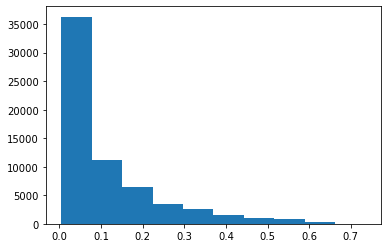

In [5]:
pl_sub =  pd.read_csv('/kaggle/input/tot-blend-for-pl-0615/submission.csv')
plt.hist(pl_sub.toxic)

In [6]:
THRESHOLD = np.percentile(pl_sub.toxic, 85)
y_test = (pl_sub.toxic.values>THRESHOLD).astype('int')
print(np.mean(y_test))
print(len(y_test))

0.15000313420673228
63812


In [7]:
lang_test = test['lang'].values
lang_wt = np.zeros(len(test))
lang_wt[lang_test == 'it'] = 0.7
lang_wt[lang_test == 'es'] = 0.8
lang_wt[lang_test == 'pt'] = 0.9
lang_wt[lang_test == 'fr'] = 1.0
lang_wt[lang_test == 'ru'] = 1.1
lang_wt[lang_test == 'tr'] = 1.2

### Load Datasets from Data Module

In [8]:
%%time

x_train = np.load(os.path.join(DATA_PATH, 'x_train.npy'))
y_train = np.load(os.path.join(DATA_PATH, 'y_train.npy'))
x_valid = np.load(os.path.join(DATA_PATH, 'x_valid.npy'))
y_valid = np.load(os.path.join(DATA_PATH, 'y_valid.npy'))
x_test = np.load(os.path.join(DATA_PATH, 'x_test.npy'))

CPU times: user 0 ns, sys: 1.96 s, total: 1.96 s
Wall time: 2.41 s


# ROC Callback

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import roc_auc_score

class RocAucCallback(Callback):
    def __init__(self, valid, valid_ds):
        self.valid = valid
        self.valid_ds = valid_ds
        # self.test_pred = []
        
    def on_epoch_end(self, epoch, logs=None):
        print(roc_auc_score(self.valid['toxic'], self.model.predict(self.valid_ds)))

# LR Scheduler

In [10]:
def build_lrfn(lr_start=1e-5, lr_max=2e-5, 
               lr_min=1e-6, lr_rampup_epochs=5,
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

# Focal Loss

In [11]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

# Build Model

In [12]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]

    mean_token = GlobalAveragePooling1D()(sequence_output)
    max_token = GlobalMaxPooling1D()(sequence_output)
    all_token = Concatenate(name = "all_token")([mean_token, max_token])
    all_token = Dropout(0.3)(all_token)
    out = Dense(1, activation='sigmoid')(all_token)
    
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=6e-6), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

# Start Training

In [13]:
import matplotlib.pyplot as plt

early_stop_cb = EarlyStopping(monitor='val_auc', 
               mode='max',
               restore_best_weights=True, 
               verbose=2,
               patience=10)

In [14]:
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(PRESAVED_MODEL)
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=MAX_LEN)
    
print("\n Loading model weights \n")

model.load_weights(os.path.join(MODEL_PATH, "model.h5"))
print("load weights done\n")


 Loading model weights 

load weights done



### PL on aug test

In [15]:
x_test_aug = np.load(os.path.join(DATA_AUG_PATH, 'x_test.npy'))
# assign language code
x_test_aug[:, 2:] = x_test_aug[:, 1:-1]
x_test_aug[:, 1] = x_test[:, 1]

In [16]:
x_test

array([[     0,   4448,  52625, ...,      1,      1,      1],
       [     0,    882,    417, ...,      1,      1,      1],
       [     0,    217, 132554, ...,      1,      1,      1],
       ...,
       [     0,    217,   2083, ...,      1,      1,      1],
       [     0,   4448, 191059, ...,      1,      1,      1],
       [     0,     90,   1413, ...,      1,      1,      1]])

In [17]:
x_test_aug

array([[    0,  4448,    40, ...,     1,     1,     1],
       [    0,   882,   417, ...,     1,     1,     1],
       [    0,   217,  1215, ...,     1,     1,     1],
       ...,
       [    0,   217,  2083, ...,     1,     1,     1],
       [    0,  4448,  1945, ...,     1,     1,     1],
       [    0,    90, 89412, ...,     1,     1,     1]])

In [18]:
y_test_aug = y_test.copy()
print(np.mean(y_test_aug))

0.15000313420673228


### Merge data

In [19]:
# sample opus and merge
x_test_pl = np.concatenate((x_train[:120000],x_test,x_test_aug),axis=0)
y_test = np.concatenate((y_train[:120000],y_test,y_test_aug),axis=0)

In [20]:
weight_test = np.concatenate((np.ones(len(x_train)), lang_wt, lang_wt))

In [21]:
#shuffle
indices = np.arange(x_test_pl.shape[0])
np.random.shuffle(indices)
x_test_pl = x_test_pl[indices]
y_test = y_test[indices]
weight_test = weight_test[indices]

In [22]:
print(x_test_pl.shape)
print(y_test.shape)
print(weight_test.shape)

(247624, 192)
(247624,)
(247624,)


### Tensorflow Dataset

In [23]:

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)


test_pl_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test_pl, y_test, weight_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)



In [24]:
!pip install keras-swa

     |████████████████████████████████| 77 kB 1.9 MB/s 
  Created wheel for keras-swa: filename=keras_swa-0.1.5-py3-none-any.whl size=9712 sha256=9bbff06a75f249b57163325e26b1615388236ac901c1bcf892de946178e25da1
  Stored in directory: /root/.cache/pip/wheels/75/fa/17/c0a0e1d12843447b81a19a262ae416d0f7e08e604d5abbd3fe
Successfully built keras-swa


In [25]:
import math
def build_cosine_annealing_lr(eta_min=3e-6, eta_max=1e-5, T_max=10):
    def lrfn(epoch):
        lr = eta_min + (eta_max - eta_min) * (1 + math.cos(math.pi * epoch / T_max)) / 2
        return lr
    return lrfn
_lrfn = build_cosine_annealing_lr(eta_min=3e-6, eta_max=9e-6, T_max=2)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(_lrfn, verbose=1)

In [26]:
from swa.tfkeras import SWA
swa_cb = SWA(start_epoch=5, 
          lr_schedule='manual', 
          swa_lr=3e-6,
          verbose=1)

In [27]:
EPOCHS = 15
n_steps = x_test_pl.shape[0] // BATCH_SIZE // EPOCHS
model.fit(
    test_pl_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[swa_cb, lr_schedule]
)



Epoch 00001: LearningRateScheduler reducing learning rate to 9e-06.
Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


128/128 [==============================] - 91s 711ms/step - loss: 0.0223 - auc: 0.9768 - lr: 9.0000e-06 - val_loss: 0.0368 - val_auc: 0.9413

Epoch 00002: LearningRateScheduler reducing learning rate to 6e-06.
Epoch 2/15
128/128 [==============================] - 60s 466ms/step - loss: 0.0209 - auc: 0.9801 - lr: 6.0000e-06 - val_loss: 0.0343 - val_auc: 0.9439

Epoch 00003: LearningRateScheduler reducing learning rate to 3e-06.
Epoch 3/15
128/128 [==============================] - 60s 467ms/step - loss: 0.0197 - auc: 0.9827 - lr: 3.0000e-06 - val_loss: 0.0368 - val_auc: 0.9426

Epoch 00004: LearningRateScheduler reducing learning rate to 5.999999999999999e-06.
Epoch 4/15
128/128 [==============================] - 60s 468ms/step - loss: 0.0194 - auc: 0.9826 - lr: 6.0000e-06 - val_loss: 0.0397 - val_auc: 0.9420

Epoch 00005: starting stochastic weight averaging

Epoch 00005: LearningRateScheduler reducing learning rate to 9e-06.
Epoch 5/15
128/128 [==============================] - 68s 53

In [28]:
valid_pred_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_valid)
    .batch(BATCH_SIZE)
)
valid['pred'] = model.predict(valid_pred_dataset, verbose=1)
## early stop didn't save best model
print("valid auc", roc_auc_score(valid['toxic'], valid['pred']))

valid.to_csv('valid_pred.csv', index=False)

63/63 [==============================] - 16s 256ms/step
valid auc 0.9411753791836293


In [29]:
test_pred_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)
test['pred'] = model.predict(test_pred_dataset, verbose=1)
test.to_csv('test_pred.csv', index=False)

499/499 [==============================] - 63s 126ms/step


# Save Model

In [30]:
%%time
MODEL_NAME = "model.h5"
model.save_weights("model.h5")
## TO LOAD:
# with strategy.scope():
#     model2 = build_model(transformer_layer, max_len=MAX_LEN)
#     model2.load_weights("model.h5")

CPU times: user 1.98 s, sys: 3.62 s, total: 5.6 s
Wall time: 8.16 s
